In [66]:
import os
import pandas as pd
import re

def read_files_in_directory(directory):
    return [entry.path for entry in os.scandir(directory) if entry.is_file()]

def extract_data_from_file(filename, keyword, process_line):
    try:
        with open(filename, 'r') as file:
            for line in file:
                if keyword in line:
                    return process_line(line)
    except Exception as e:
        print(f"Error reading {filename}: {e}")
    return None

def extract_voltage(filename):
    
    try:
        with open(filename, 'r') as file:
            for line in file:
                voltage_match = re.search(r'volt=(\d+)', line)
                if voltage_match:
                    return float(voltage_match.group(1))/ 1000.0
    except Exception as e:
        print(f"Error extracting voltage from {filename}: {e}")
    return 3.7  

def get_computed_drain_energy(filename):
    voltage = extract_voltage(filename)
    def process_line(line):
        drain_value_str = re.search(r'Computed drain: ([\d.]+)', line)
        if drain_value_str:
            drain_value = float(drain_value_str.group(1))
            return drain_value * voltage * 3.6
        return None
    return extract_data_from_file(filename, 'Computed drain', process_line)

def get_screen_energy_and_duration(filename):
    voltage = extract_voltage(filename)
    def process_line(line):
        energy_mah = float(line.split()[1])
        duration = line.split('duration:')[-1].strip()
        energy_joules = energy_mah * voltage * 3.6
        return energy_joules, duration
    return extract_data_from_file(filename, 'screen:', process_line)

def get_uid_energy_joules(filename, uid):
    voltage = extract_voltage(filename) 
    def process_line(line):
        uid_value_str = re.search(rf'{uid}: ([\d.]+)', line)
        if uid_value_str:
            uid_value = float(uid_value_str.group(1))
            return uid_value * voltage * 3.6
        return None
    return extract_data_from_file(filename, uid, process_line)

def read_execution_data(directory):
    results = []
    battery_files = read_files_in_directory(directory)
    for battery_file in battery_files:
        voltage = extract_voltage(battery_file)  
        computed_drain_joules = get_computed_drain_energy(battery_file)
        screen_energy_joules, duration = get_screen_energy_and_duration(battery_file) if get_screen_energy_and_duration(battery_file) else (None, None)
        uid_energy_joules = get_uid_energy_joules(battery_file, 'UID u0a424')
        results.append([voltage, computed_drain_joules, screen_energy_joules, duration, uid_energy_joules])
    return results

def run_experiment(directory):
    data = read_execution_data(directory)
    df = pd.DataFrame(data, columns=['Volt', 'Computed Drain', 'Screen Energy', 'Duration', 'UID u0a424'])
    return df.dropna()

directory = 'C:\\Users\\tomas\\OneDrive\\Ambiente de Trabalho\\dados TFC\\testFlashlightEnergyConsumption1m'
df = run_experiment(directory)
print(df)

     Volt  Computed Drain  Screen Energy     Duration  UID u0a424
0   4.198        241.8048      26.447400  1m 2s 764ms   45.489528
1   4.235        182.9520      25.613280  1m 0s 331ms   44.975700
2   4.235         91.4760      25.765740  1m 0s 676ms   44.975700
3   4.156        104.7312      24.088176    57s 609ms   42.042096
4   4.212        197.1216      25.474176  1m 0s 387ms   44.883072
5   4.212        181.9584      25.777440  1m 0s 994ms   44.731440
6   4.198        287.1432      25.540632  1m 0s 452ms   44.582760
7   4.235         76.2300      25.613280  1m 0s 295ms   44.975700
8   4.235        228.6900      25.003440  1m 0s 437ms   44.975700
9   4.235        213.4440      25.460820  1m 0s 434ms   44.975700
10  4.235        243.9360      25.613280  1m 0s 384ms   44.975700
11  4.235        198.1980      25.613280  1m 0s 320ms   44.823240
12  4.235        289.6740      25.613280  1m 0s 323ms   44.975700
13  4.235        243.9360      25.613280  1m 0s 368ms   44.975700


In [67]:
import pandas as pd
from scipy.stats import f_oneway

computed_drain = df['Computed Drain']
screen_energy = df['Screen Energy']
uid_energy = df['UID u0a424']

resultado = f_oneway(computed_drain, screen_energy, uid_energy)
print("P-value:", resultado.pvalue)

P-value: 8.345856914051694e-15


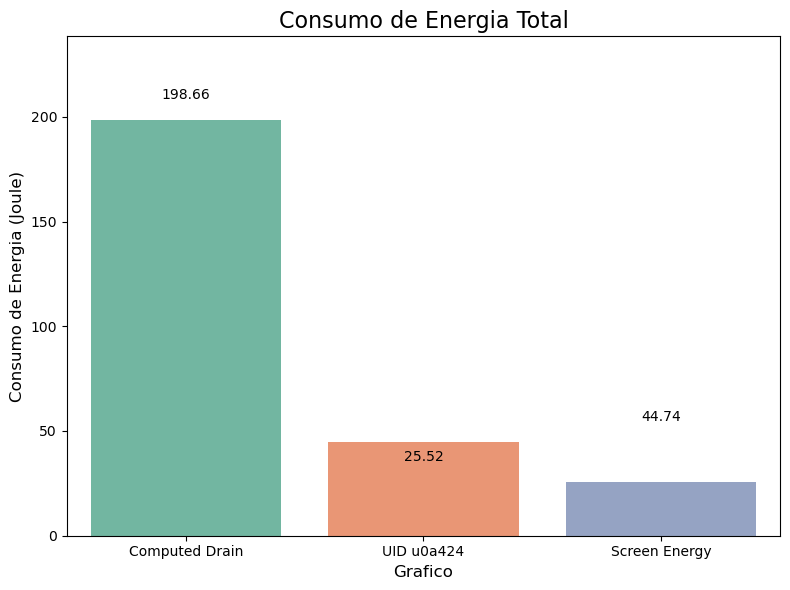

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


directory = 'C:\\Users\\tomas\\OneDrive\\Ambiente de Trabalho\\dados TFC\\testFlashlightEnergyConsumption1m'
df = run_experiment(directory)


mean_screen_energy = df['Screen Energy'].mean()
mean_uid_energy = df['UID u0a424'].mean()
mean_computed_drain = df['Computed Drain'].mean()


data = {
    'Category': ['Computed Drain', 'Screen Energy', 'UID u0a424'],
    'Mean Energy (Joule)': [mean_computed_drain, mean_screen_energy, mean_uid_energy]
}
df_means = pd.DataFrame(data)


df_means = df_means.sort_values(by='Mean Energy (Joule)', ascending=False)


plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Mean Energy (Joule)', data=df_means, palette='Set2')


plt.ylim(0, df_means['Mean Energy (Joule)'].max() * 1.2)


for index, row in df_means.iterrows():
    plt.text(index, row['Mean Energy (Joule)'] + (df_means['Mean Energy (Joule)'].max() * 0.05), 
             f"{row['Mean Energy (Joule)']:.2f}", color='black', ha="center")


plt.title('Consumo de Energia Total', fontsize=16)
plt.ylabel('Consumo de Energia (Joule)', fontsize=12)
plt.xlabel('Grafico', fontsize=12)

plt.tight_layout()
plt.show()

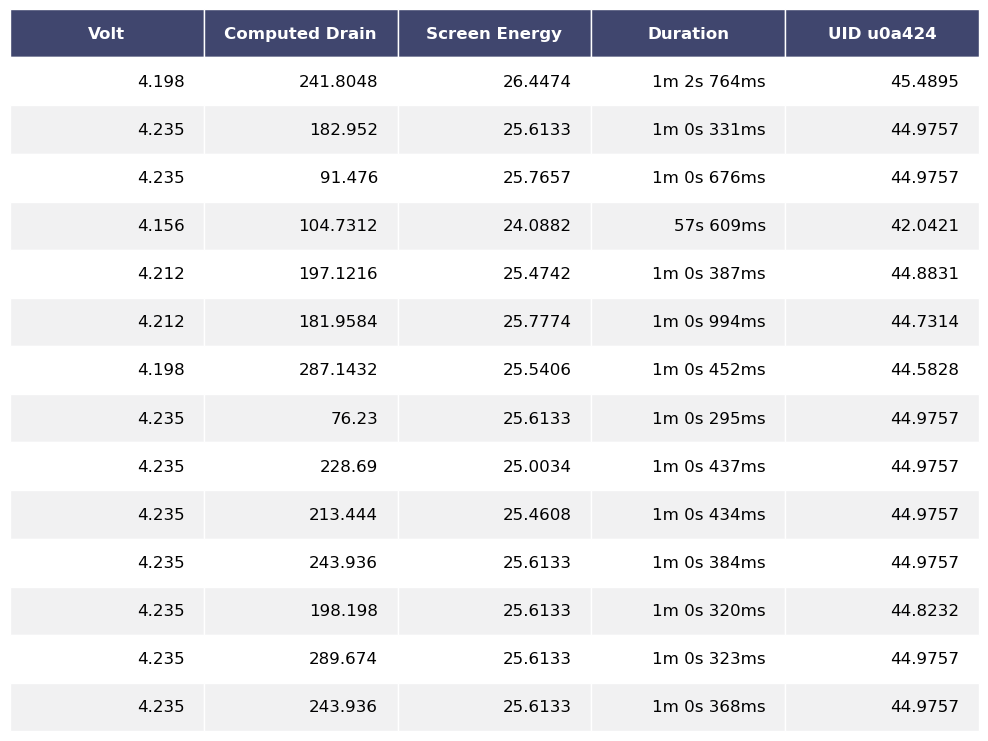

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


directory = 'C:\\Users\\tomas\\OneDrive\\Ambiente de Trabalho\\dados TFC\\testFlashlightEnergyConsumption1m'
df = run_experiment(directory)


df = df.round(4)


def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    plt.savefig("table_image.png", bbox_inches='tight', pad_inches=0.1)


render_mpl_table(df, header_columns=0, col_width=2.5)
plt.show()



In [ ]:

if 'Duration' in df.columns:
   
    def format_duration(duration_str):
        if not isinstance(duration_str, str):
            return duration_str
        total_seconds = 0
        parts = duration_str.split()
        for part in parts:
            if 'm' in part:
                total_seconds += int(part.replace('m', '')) * 60
            elif 's' in part:
                total_seconds += int(part.replace('s', ''))
            elif 'ms' in part:
                total_seconds += int(part.replace('ms', '')) / 1000
        return f"{total_seconds:.2f}s"

    
    df['Duration'] = df['Duration'].apply(format_duration)


numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].round(4)


def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    plt.savefig("table_image.png", bbox_inches='tight', pad_inches=0.1)


render_mpl_table(df, header_columns=0, col_width=2.5)
plt.show()